# [H&M] Postal-code Grouping

**This is the sequel version to my previous notebook below.**  
https://www.kaggle.com/code/junjitakeshima/h-m-easy-grouping-by-sex-attribute-age-en-jp  

**[Original Aim]**  
The target period for this competition's scoring is 1week of late September. This "late September" is a bit subtle timing, because Autmn is coming in some countries(e.g. Sweden where H&M HQ exists) while other countries are still enjoying Summer (e.g. Indonesia). If such Season can be grouped, the score could be improved.   

スコアの対象となるのは9月下旬の1週間に売れた商品。この9月下旬というのが微妙で、秋が始まりつつある国もあれば（例えばH&Mの本国スウェーデン）、常夏の国もあるはず（例えばインドネシア）。そうした季節感の異なる地域毎にグルーピングをすればスコアは改善するのではないか。  

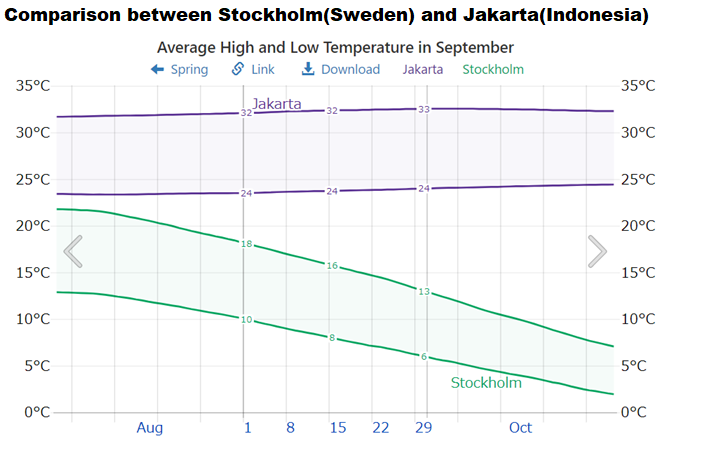

**[Approach]**  
First Approach  : tried to find "Country" information in postal_code (... fail)  
　　　　　　　　　　　(but, I found the first 10 digits of 64 can make postal_code unique)  
           
Second Approach :  
(1) Define the postal code area (maybe "town") where "Sweater" or "Coat" are sold in September as winter-coming area  
(2) Grouping by customers in winter-coming area and others  
(3) Recommend most-sold items grouped by Age, Sex/attribute, and Area.  

The result was not as expected (slightly got worse from 0.0078->0.0069).

最初のアプローチ：　郵便番号の中に国情報が入っているのではないかと考え、それを見つけようとした（が、断念。。）  
　　　　　　　　　　（ただ、郵便番号64桁のうち最初の10桁でユニークになっていることに気づき、その10桁をエリアコードとして使いました）  
次のアプローチ　：  
(1) 9月に入ってからセーターまたはコートが売れている郵便番号エリアを冬間近地域として定義  
(2) 顧客を冬間近地域に住む顧客とそれ以外に分類  
(3) 年齢・性別/属性・地域区別に応じてグルーピングして最も売れたアイテムをおススメ

結果としては当初の狙い通りのスコアにはならなかった（0.0078→0.0069へと僅かに悪化）

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from datetime import datetime, date, timedelta

from collections import Counter, defaultdict
from PIL import Image
from pathlib import Path

path = Path("/kaggle/input/h-and-m-personalized-fashion-recommendations/")
pd.set_option("display.max_columns", None)

# 1. Reading Dataframes

In [ ]:
transactions_df = pd.read_csv(path / "transactions_train.csv", dtype = {'article_id': str})
articles_df = pd.read_csv(path / "articles.csv", dtype = {'article_id': str})
customers_df = pd.read_csv(path / "customers.csv")
submission = pd.read_csv(path / "sample_submission.csv")

In [ ]:
transactions_df["t_dat"] = pd.to_datetime(transactions_df['t_dat'])
transactions_df

In [ ]:
customers_df

# 2. Insight for Postal Code

As you can see, the postal code is Hexadecimal(16) x 64digit. Why this long??  
However, unique nymber is 352,899 while total count is 1,371,980. Let's see more in detail.  

ご覧の通り、郵便番号は16進数の64桁。なんでこんなに長いんだ？  
ただ、総数1,371,980に対し、ユニーク数は352,899。64桁全てを使ってユニークになっているわけではなさそう。もう少し見てみよう。

In [ ]:
display(customers_df["postal_code"].describe())
print("postal code length = ", len(customers_df.loc[0, "postal_code"]))

Let's split the postal code, and see how many digits make the postal code unique. 

64桁を一度バラして、何桁でユニークになっているのかを見てみる。

In [ ]:
post_df = customers_df["postal_code"].str.split('', expand=True)
post_df["1_2"] = post_df[1].str.cat(post_df[2])
for i in range(8) :
    post_df[f"1_{i+3}"] = post_df[f"1_{i+2}"].str.cat(post_df[i+3])

Let's see the conbination of 1st to 2nd digit, 1st to 3rd・・・until 1st to 10th digit.  
As you can see, first 10digits make the postal code unique.  

1-2桁目、1-3桁目・・という具合に1-10桁目までの組み合わせを見てみる。  
ご覧の通り、最初の10桁でユニークになっていることが分かる。

In [ ]:
a = post_df[1].nunique()
print("1st dig: counts =",  a)
for i in range(9) :
    b = post_df[f"1_{i+2}"].nunique()
    print(f"1 to {i+2} : counts =",  b, "   above row *", b/a)
    a = b

# 3. Try to classify customers who live in Winter-coming area and others

But failed to find the information to indicate/suggest "country", and eventually gave up..  
Continue to try 2nd approach (try to define the area where winter items are sold as "winter-coming area").  

ただ、結局国を表す情報がどこにあるのかは見つからず、最初のアプローチ(国単位でグルーピング)は断念。  
2番目のアプローチ（冬物が売れている地域を冬間近地域として定義）を試してみる。

In [ ]:
articles_df.head()

There are dozens of product-type names. Out of them, let's choose "Sweater" and "Coat" as typical winter-items.  
製品タイプは何十個とあるが、この中から冬物として「セーター」と「コート」を使うことにする。

In [ ]:
articles_df["product_type_name"].unique()

Sweater or Coat items are more than 9000. I never thought such many items exist.  
セーターまたはコートだけで9000アイテム以上。こんなにあるんだ。

In [ ]:
articles_df[articles_df["product_type_name"]==("Sweater" or "Coat")]

In [ ]:
customers_df = pd.concat([customers_df, post_df["1_10"].reset_index(drop = True)], axis=1)
customers_df = customers_df.rename(columns = {"1_10" : "town"})
customers_df = customers_df.drop("postal_code", axis = 1)
customers_df

In [ ]:
articles_df.loc[(articles_df["product_type_name"]==("Sweater" or "Coat")), "season"] = 1
articles_df.fillna(0, inplace = True)

In [ ]:
custom_temp = pd.DataFrame(customers_df[["customer_id", "town"]])
trans_temp  = transactions_df.copy()
trans_temp = pd.merge(trans_temp, custom_temp, on = "customer_id", how = "left")

article_temp = pd.DataFrame(articles_df[["article_id", "season"]])
trans_temp = pd.merge(trans_temp, article_temp, on = "article_id", how = "left")
trans_temp = trans_temp.loc[trans_temp.t_dat >= pd.to_datetime('2020-09-01')]

region_df = trans_temp[["town", "season"]].groupby("town").sum().reset_index()

it seems that the customers who live in the area where sweater/coat were sold in September-2020 are apprx 30% of the total customers.  
9月に入ってセーター・コートが売れた地域に住んでいる顧客は顧客全体の3割程度のようだ。

In [ ]:
region_df.loc[region_df["season"]>10, "season"] = 10
region_df["season"].plot.hist(bins=10)

In [ ]:
region_df.loc[(region_df["season"] >0), "season"] = 1

print("number of regions which have transactions after 2020-09-01 = : ", len(region_df))
print("number of Winter-coming regions", region_df["season"].sum())

In [ ]:
customers_df = pd.merge(customers_df, region_df, on = "town", how ="left") 
customers_df["season"].fillna(0, inplace = True)

temp = customers_df["season"].value_counts().index.to_list()
plt.figure(figsize=(5, 5))
plt.rcParams["font.size"] = 12
plt.pie(customers_df["season"].value_counts().sort_values(ascending=False), 
        labels = temp, startangle = 90, counterclock=False, autopct="%1.1f%%")
plt.show

# 4. Grouping by Age

The contents hereafter is basically same as my previous notebook below, and hence I'll omit the explanation.

ここからは、前回のNotebookと基本的に同一ですので、解説は省略します。

https://www.kaggle.com/code/junjitakeshima/h-m-easy-grouping-by-sex-attribute-age-en-jp

In [ ]:
customers_df["age"].plot.hist(bins=50)

In [ ]:
age_id = 0
age_group = pd.DataFrame(columns =["age","age_id"])
age=16

for i in range(53) :
    if age < 30 :
        temp_group = pd.DataFrame({"age":[age, age+1], "age_id":[age_id, age_id]})
        age_group = age_group.append(temp_group)
        age += 2
        age_id += 1
    elif  age < 60 :
        temp_group = pd.DataFrame({"age":[age, age+1, age+2, age+3, age+4],"age_id":[age_id, age_id, age_id, age_id, age_id]})
        age_group = age_group.append(temp_group)
        age += 5
        age_id += 1
    else:
        temp_group = pd.DataFrame({"age":[age], "age_id":[age_id]})
        age_group = age_group.append(temp_group)
        age += 1

16-99 age will be grouped into age_id 0-13.   

16~99歳の年齢を0～13までのage_idにグルーピング

In [ ]:
age_group

In [ ]:
customers_df = pd.merge(customers_df, age_group, on="age", how = "left")
customers_df = customers_df.drop(["FN", "Active", "club_member_status", "fashion_news_frequency"], axis=1)
customers_df

# 5. Grouping by Sex/Attribute

**Approach**  
(1) Based on "index_group_name" in article list, Purchase history will be classified as "Women's item", "Men's item", "Kid's item", etc.  
(2) Based on the purchase history, classify the customers into 5 attributes, guessing those who purchased more Women's items are Women, and those who purchased more Men's items are Men, etc.  

**アプローチ**  
(1) 品目リストのindex_group_nameをもとに、購入履歴を女性用品・男性用品・子供用品等に分類  
(2) 女性用の購入履歴が多い顧客を女性、男性用の購入履歴が多い顧客を男性、という具合に顧客層を5つの属性に分類  
　　（女性　／　ヤング(Divided)　／　男性　／　子持ち　／　スポーツパーソン）

In [ ]:
articles_df.head(5)

In [ ]:
print(articles_df["index_group_name"].unique())
print(articles_df["index_group_no"].unique())

In [ ]:
sex_category = articles_df[["index_group_no", "index_group_name"]].reset_index()
display(sex_category["index_group_name"].value_counts())

In [ ]:
sex_category_list = sex_category["index_group_name"].value_counts().index.to_list()
plt.figure(figsize=(5, 5))
plt.rcParams["font.size"] = 12
plt.pie(sex_category["index_group_name"].value_counts().sort_values(ascending=False), 
        labels = sex_category_list, startangle = 90, counterclock=False, autopct="%1.1f%%")
plt.show

In [ ]:
del sex_category_list

In [ ]:
articles_category_df = pd.DataFrame(articles_df[["article_id", "index_group_no"]])
articles_category_df.columns = ["article_id", "sex_attribute"]
articles_category_df

In [ ]:
transactions_df = pd.merge(transactions_df, articles_category_df, on = "article_id", how = "left")
transactions_df

In [ ]:
cust_sex = transactions_df[["customer_id", "sex_attribute", "article_id"]].groupby(["customer_id","sex_attribute"]).count().unstack()
cust_sex.columns = ["Woman", "Young", "Man", "Have-kids", "Sports-person"]
cust_sex

In [ ]:
%%time
cust_sex["attribute"] = cust_sex.apply(lambda x : list(x[x == x.max()].index), axis=1)
cust_sex

In [ ]:
cust_sex1 = pd.DataFrame(cust_sex[["attribute"]]).reset_index()
cust_sex1["attribute"] = cust_sex1["attribute"].apply(",".join).astype(str)
del cust_sex
cust_sex1

In [ ]:
print(cust_sex1.attribute.unique())

In [ ]:
cust_sex1.loc[~((cust_sex1["attribute"] == "Woman") |
               (cust_sex1["attribute"] == "Young")  |
               (cust_sex1["attribute"] == "Man")    |
               (cust_sex1["attribute"] == "Have-kids") |
               (cust_sex1["attribute"] == "Sports-person")), "attribute"] = "Woman"
cust_sex1

In [ ]:
print(cust_sex1.attribute.unique())

In [ ]:
temp = cust_sex1["attribute"].value_counts().index.to_list()
plt.figure(figsize=(5, 5))
plt.rcParams["font.size"] = 12
plt.pie(cust_sex1["attribute"].value_counts().sort_values(ascending=False), 
        labels = temp, startangle = 90, counterclock=False, autopct="%1.1f%%")
plt.show

In [ ]:
print(cust_sex1["attribute"].value_counts().sort_values(ascending=False))

In [ ]:
customers_df = pd.merge(customers_df, cust_sex1, on ="customer_id", how="left")
customers_df

In [ ]:
customers_df.isnull().sum()

In [ ]:
customers_df["attribute"].fillna("Woman", inplace = True)

In [ ]:
age_mean = customers_df[["age", "attribute"]].groupby("attribute").mean().round().reset_index()
age_mean.columns = ["attribute", "age_mean"]
age_mean

In [ ]:
customers_df = pd.merge(customers_df, age_mean, on = "attribute", how ="left")
customers_df.loc[(customers_df["age"].isnull()), "age"] = customers_df["age_mean"]
customers_df = customers_df.drop(["age_mean", "age_id"], axis =1)
customers_df = pd.merge(customers_df, age_group, on="age", how="left")
customers_df.isnull().sum()

In [ ]:
del cust_sex1
del post_df
del custom_temp
del article_temp
del trans_temp

In [ ]:
transactions_df = pd.merge(transactions_df, customers_df, on ="customer_id", how ="left")
transactions_df.isnull().sum()

# 6. Make prediction

In addition to "age_id" and "sex/attribute", region factor was also added. Therefore, some group have only a couple of items for recommendation. For those groups, the items derived from only age and sex/attribute factors (=recommend_2) will be recommended.

前回の「年齢階層」「性別/属性」に加えて「地域」もグルーピング要素に加えたため、グループによっては売り上げ品目が２・３個に満たないグループが発生。こうしたグループには、「年齢階層」「性別/属性」のみのグルーピングによる売り上げ上位品目(recommend_2)を適用。

In [ ]:
trans_df = transactions_df.loc[transactions_df.t_dat >= pd.to_datetime('2020-09-15')].copy() # changed from 2020-09-01
trans_df

In [ ]:
trans_df.article_id = ' ' + trans_df.article_id.astype('str')
temp = trans_df.groupby(['age_id','attribute','season','article_id'])['customer_id'].agg('count').reset_index()
temp.columns = ['age_id','attribute','season','article_id','count']
trans_df = trans_df.merge(temp, on=['age_id','attribute','season','article_id'], how='left')
trans_df

In [ ]:
trans_df = trans_df.sort_values(['count','t_dat'],ascending=False)
trans_df = trans_df.drop_duplicates(['age_id','attribute','season','article_id'])
trans_df

In [ ]:
recommend_2 = pd.DataFrame(trans_df.groupby(['age_id','attribute']).article_id.sum().reset_index())
recommend_2["len"] = recommend_2["article_id"].apply(lambda x : len(x))
recommend_2

As you see below, for example, only 32 items ware sold for age_id=0(16-17 years old) Sports-person who live in warm area (sweater/coat is not sold). For those layers, the items based on age and sex/atrribute only will be recommended. 

例えば、age_idが0（16歳・17歳）でセーター・コートが売れていない地域に住むスポーツパーソンでは、9月に入って品目が2個しか売れていない。このような顧客階層には、地域要素を除いた売れ行き品目を適用する。

In [ ]:
recommend_1 = pd.DataFrame(trans_df.groupby(["age_id",'attribute',"season"]).article_id.sum().reset_index())
recommend_1["len"] = recommend_1["article_id"].apply(lambda x : len(x))
recommend_1

In [ ]:
recommend_1 = pd.merge(recommend_1, recommend_2, on = ["age_id","attribute"], how ="left")
recommend_1

In [ ]:
recommend_1["article_id"] = recommend_1.loc[recommend_1["len_x"]<131, "article_id_y"]
recommend_1["article_id"].fillna(recommend_1["article_id_x"], inplace =True)
recommend_1 = recommend_1.drop(["article_id_x","len_x","article_id_y","len_y"], axis=1)
recommend_1

In [ ]:
recommend_1["article_id"] = recommend_1["article_id"].str.strip()
recommend_1["article_id"] = recommend_1["article_id"].str[:131]

In [ ]:
submission = pd.read_csv('../input/h-and-m-personalized-fashion-recommendations/sample_submission.csv')
submission = submission[['customer_id']]
submission = pd.merge(submission, customers_df, on = "customer_id", how = "left")
submission = pd.merge(submission, recommend_1, on = ["age_id",'attribute',"season"], how="left")
submission = submission.drop(["age", "age_id", "attribute", "town", "season"], axis =1)
submission.columns = ("customer_id", "prediction")
submission.to_csv("submission.csv",index=False)
submission